Задание в рамках программы курса Deep Learning School МФТИ:

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



Метрика качества классификации - f1-score.

In [1]:
import os
from os.path import exists
import torch
import numpy as np
import PIL
from google.colab import drive

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


## Данные:

Примонтируем гугл-драйв и распакуем датасеты:

In [3]:
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/My\ Drive/simpsons/dataset.zip -d train
!unzip -q /content/gdrive/My\ Drive/simpsons/testset.zip -d test
!ls train

simpsons_dataset


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$$input = \frac{input - \mu}{\text{standard deviation}}  $$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размеру. 

### Аугментация

В метод __getitem__ добавлена аугментация в зависимости от того является ли объект из выборки 'train', 'test' или 'val'. В зависимости от этого к нему либо применяются трансформации, либо нет.

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_train = transforms.Compose([
          transforms.RandomHorizontalFlip(),
          transforms.RandomRotation(20),
          transforms.RandomResizedCrop(244),
          # transforms.Resize(256),
          # transforms.CenterCrop(244),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
        transform_test = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(244),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
        x = self.load_sample(self.files[index])
        #x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        x_train = transform_train(x)
        x_test = transform_test(x)
        if self.mode == 'train':
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x_train, y
        elif self.mode == 'val':
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x_test, y
        else:
            return x_test
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
TRAIN_DIR = Path('train')
TEST_DIR = Path('test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

### Oversampling

Классы не сбалансированы, то есть некоторые персонажи будут показываться сетке чаще других. Реализуем oversampling, чтобы классы, в которых мало картинок встречались чаще. При этом из-за аугментации они не будут всегда одинаковыми.

In [0]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [0]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [0]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [0]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [12]:
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [0]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(train_files, mode='train')

Посмотрим на наших героев внутри датасета:

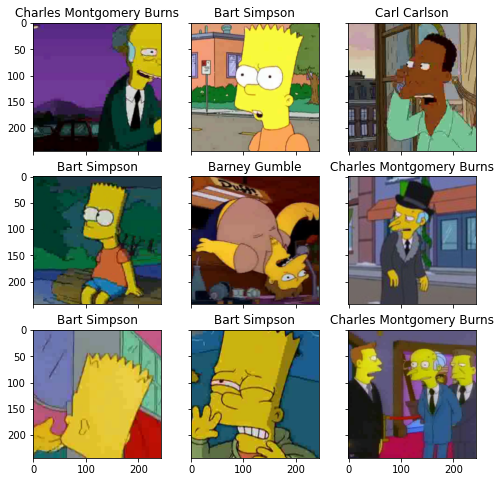

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Обучение моделей

Напишем функции для работы с моделью:

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, optimizer, scheduler, epochs, batch_size):
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step()
    return history

In [0]:
def train_no_scheduler(train_files, val_files, model, optimizer, epochs, batch_size):
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## ResNet18

Объем обучающей выборки около 20к картинок, попробуем сначала не самые сложные и громоздкие архитектуры.

### **Feature Extractor** способ:

Возьмём предобученную на ImageNet модель, отбросим зафиксируем несколько первых слоев и обучим оставшиеся.

In [0]:
model_extractor = models.resnet18(pretrained=True)

Вспомним, как выглядит ResNet18:

In [0]:
model_extractor

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Изменим модель:

In [0]:
# Заменим последний линейный слой на полносвязный с нужным количеством классов
num_classes = 42
model_extractor.fc = nn.Linear(512, num_classes, bias = True)

# замораживаем все параметры (веса) модели
for param in model_extractor.parameters():
    param.requires_grad = False
    
# Разморозим пару последних слоев
# полносвязный
layers_to_unfreeze = 1
for param in model_extractor.fc.parameters():
    param.requires_grad = True
    
# 3-й слой
for param in model_extractor.layer3.parameters():
    param.requires_grad = True
    
# 4-й слой
for param in model_extractor.layer4.parameters():
    param.requires_grad = True

model_extractor = model_extractor.to(DEVICE)

In [0]:
# посмотрим какие параметры нейросети мы учим
params_to_update = model_extractor.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_extractor.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer3.1.bn2.bias
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [0]:
# В качестве оптимизатора AdaShift из репозитория МФТИ
#opti = torch.optim.AdamW(params_to_update, lr=1e-3, amsgrad=True)
opti = torch.optim.SGD(model_extractor.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(opti, step_size=12, gamma=0.1)

In [0]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

Обучим немножко модель:

In [0]:
history = train(train_dataset, val_dataset, model_extractor,opti,exp_lr_scheduler, epochs=12, batch_size=128)

epoch:   0%|          | 0/12 [00:00<?, ?it/s]

loss 2.624821131757448


epoch:   8%|▊         | 1/12 [03:23<37:16, 203.31s/it]


Epoch 001 train_loss: 2.6248     val_loss 1.7474 train_acc 0.3703 val_acc 0.6656
loss 0.8715140204861237


epoch:  17%|█▋        | 2/12 [06:41<33:38, 201.90s/it]


Epoch 002 train_loss: 0.8715     val_loss 0.6096 train_acc 0.8023 val_acc 0.8412
loss 0.4130867775405043


epoch:  25%|██▌       | 3/12 [09:59<30:06, 200.74s/it]


Epoch 003 train_loss: 0.4131     val_loss 0.4062 train_acc 0.8931 val_acc 0.8942
loss 0.25753894744139433


epoch:  33%|███▎      | 4/12 [13:18<26:40, 200.03s/it]


Epoch 004 train_loss: 0.2575     val_loss 0.3380 train_acc 0.9347 val_acc 0.9087
loss 0.17618049803346014


epoch:  42%|████▏     | 5/12 [16:36<23:16, 199.48s/it]


Epoch 005 train_loss: 0.1762     val_loss 0.3093 train_acc 0.9541 val_acc 0.9173
loss 0.11967983883280262


epoch:  50%|█████     | 6/12 [19:55<19:55, 199.25s/it]


Epoch 006 train_loss: 0.1197     val_loss 0.3066 train_acc 0.9699 val_acc 0.9196
loss 0.07954240664986867


epoch:  58%|█████▊    | 7/12 [23:14<16:36, 199.29s/it]


Epoch 007 train_loss: 0.0795     val_loss 0.2803 train_acc 0.9814 val_acc 0.9272
loss 0.05923057646041019


epoch:  67%|██████▋   | 8/12 [26:33<13:16, 199.23s/it]


Epoch 008 train_loss: 0.0592     val_loss 0.2890 train_acc 0.9862 val_acc 0.9324
loss 0.03700723792166154


epoch:  75%|███████▌  | 9/12 [29:52<09:57, 199.11s/it]


Epoch 009 train_loss: 0.0370     val_loss 0.2815 train_acc 0.9919 val_acc 0.9348
loss 0.021760018800289015


epoch:  83%|████████▎ | 10/12 [33:11<06:38, 199.06s/it]


Epoch 010 train_loss: 0.0218     val_loss 0.2645 train_acc 0.9960 val_acc 0.9421
loss 0.013062483323955697


epoch:  92%|█████████▏| 11/12 [36:30<03:19, 199.02s/it]


Epoch 011 train_loss: 0.0131     val_loss 0.2788 train_acc 0.9985 val_acc 0.9396
loss 0.009590165479552076


epoch: 100%|██████████| 12/12 [39:48<00:00, 199.08s/it]


Epoch 012 train_loss: 0.0096     val_loss 0.2868 train_acc 0.9986 val_acc 0.9412


In [0]:
torch.save(model_extractor.state_dict(), "/content/gdrive/My Drive/simpsons/resnet18_2layers_unfreeze_noaug_batch128_12epochs.pth")

Построим кривые обучения

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

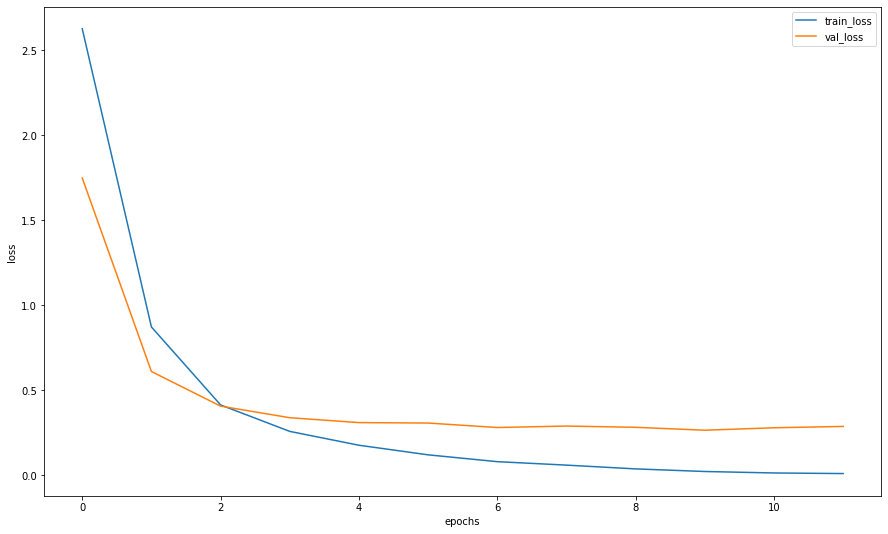

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Попробуем доучить модель ещё несколько итераций с меньшим шагом, так как начнет работать scheduler:

In [0]:
history = history + train(train_dataset, val_dataset, model_extractor,opti,exp_lr_scheduler, epochs=3, batch_size=128)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 0.0037740676054443052


epoch:  33%|███▎      | 1/3 [03:18<06:37, 198.72s/it]


Epoch 001 train_loss: 0.0038     val_loss 0.2597 train_acc 0.9998 val_acc 0.9457
loss 0.002850116684759244


epoch:  67%|██████▋   | 2/3 [06:36<03:18, 198.56s/it]


Epoch 002 train_loss: 0.0029     val_loss 0.2636 train_acc 0.9999 val_acc 0.9459
loss 0.0026358109886296015


epoch: 100%|██████████| 3/3 [09:55<00:00, 198.37s/it]


Epoch 003 train_loss: 0.0026     val_loss 0.2681 train_acc 0.9999 val_acc 0.9457


In [0]:
torch.save(model_extractor.state_dict(), "/content/gdrive/My Drive/simpsons/resnet18_2layers_unfreeze_noaug_batch128_15epochs.pth")

Построим кривые обучения

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

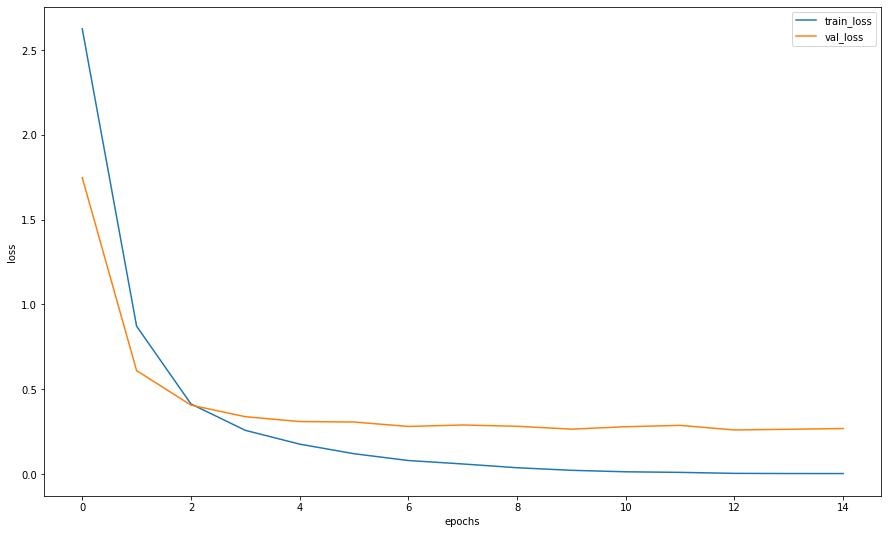

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Данный результат даёт неплохой f1-score на kaggle - около 0.96

Но обучение сетки полностью с нуля даёт лучший скор.

### Обучение с нуля

In [0]:
model_extractor = models.resnet18()

Изменим модель:

In [0]:
# Заменим последний линейный слой на полносвязный с нужным количеством классов
num_classes = 42
model_extractor.fc = nn.Linear(512, num_classes, bias = True)

# # замораживаем параметры (веса)
# for param in model_extractor.parameters():
#     param.requires_grad = False
# # Разморозим пару последних слоев
# layers_to_unfreeze = 1
# for param in model_extractor.fc.parameters():
#     param.requires_grad = True

# for param in model_extractor.layer3.parameters():
#     param.requires_grad = True

# for param in model_extractor.layer4.parameters():
#     param.requires_grad = True

model_extractor = model_extractor.to(DEVICE)

In [0]:
# посмотрим какие параметры нейросети мы учим
params_to_update = model_extractor.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_extractor.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [0]:
# В качестве оптимизатора AdaShift из репозитория МФТИ
opti = torch.optim.AdamW(model_extractor.parameters(), lr=1e-3, amsgrad=True)
# opti = torch.optim.SGD(model_extractor.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(opti, step_size=15, gamma=0.1)

In [0]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

Обучим немножко модельку:

In [77]:
history = train_no_scheduler(train_dataset, val_dataset, model_extractor,opti, epochs=60, batch_size=128)

epoch:   0%|          | 0/60 [00:00<?, ?it/s]

loss 2.479268690007258


epoch:   2%|▏         | 1/60 [03:26<3:23:23, 206.84s/it]


Epoch 001 train_loss: 2.4793     val_loss 2.2078 train_acc 0.3233 val_acc 0.4259
loss 2.7911113396944747


epoch:   3%|▎         | 2/60 [06:52<3:19:36, 206.49s/it]


Epoch 002 train_loss: 2.7911     val_loss 2.2192 train_acc 0.2154 val_acc 0.3987
loss 2.1683145226988185


epoch:   5%|▌         | 3/60 [10:18<3:15:57, 206.28s/it]


Epoch 003 train_loss: 2.1683     val_loss 1.7799 train_acc 0.4103 val_acc 0.5288
loss 1.835193640411686


epoch:   7%|▋         | 4/60 [13:43<3:12:16, 206.01s/it]


Epoch 004 train_loss: 1.8352     val_loss 1.2925 train_acc 0.4954 val_acc 0.6549
loss 1.5834468055116164


epoch:   8%|▊         | 5/60 [17:09<3:08:50, 206.02s/it]


Epoch 005 train_loss: 1.5834     val_loss 1.0970 train_acc 0.5632 val_acc 0.6918
loss 1.4223260695831481


epoch:  10%|█         | 6/60 [20:37<3:05:51, 206.52s/it]


Epoch 006 train_loss: 1.4223     val_loss 0.9862 train_acc 0.6102 val_acc 0.7363
loss 1.2760850921908233


epoch:  12%|█▏        | 7/60 [24:04<3:02:30, 206.61s/it]


Epoch 007 train_loss: 1.2761     val_loss 0.8703 train_acc 0.6490 val_acc 0.7713
loss 1.1586883411763451


epoch:  13%|█▎        | 8/60 [27:30<2:58:56, 206.47s/it]


Epoch 008 train_loss: 1.1587     val_loss 0.7174 train_acc 0.6758 val_acc 0.8072
loss 1.0845429982506658


epoch:  15%|█▌        | 9/60 [30:56<2:55:18, 206.25s/it]


Epoch 009 train_loss: 1.0845     val_loss 0.6207 train_acc 0.6974 val_acc 0.8347
loss 1.0244062902312483


epoch:  17%|█▋        | 10/60 [34:22<2:51:52, 206.25s/it]


Epoch 010 train_loss: 1.0244     val_loss 0.6473 train_acc 0.7187 val_acc 0.8273
loss 0.9744614065813482


epoch:  18%|█▊        | 11/60 [37:47<2:48:16, 206.06s/it]


Epoch 011 train_loss: 0.9745     val_loss 0.5283 train_acc 0.7297 val_acc 0.8611
loss 0.9251031314038085


epoch:  20%|██        | 12/60 [41:13<2:44:44, 205.93s/it]


Epoch 012 train_loss: 0.9251     val_loss 0.5612 train_acc 0.7386 val_acc 0.8536
loss 0.867543459014533


epoch:  22%|██▏       | 13/60 [44:38<2:41:03, 205.61s/it]


Epoch 013 train_loss: 0.8675     val_loss 0.4806 train_acc 0.7617 val_acc 0.8775
loss 0.8355479960350772


epoch:  23%|██▎       | 14/60 [48:03<2:37:24, 205.31s/it]


Epoch 014 train_loss: 0.8355     val_loss 0.4852 train_acc 0.7692 val_acc 0.8781
loss 0.8242029793187003


epoch:  25%|██▌       | 15/60 [51:27<2:33:44, 204.98s/it]


Epoch 015 train_loss: 0.8242     val_loss 0.4448 train_acc 0.7705 val_acc 0.8892
loss 0.7752228165684296


epoch:  27%|██▋       | 16/60 [54:51<2:30:13, 204.86s/it]


Epoch 016 train_loss: 0.7752     val_loss 0.4354 train_acc 0.7867 val_acc 0.8930
loss 0.7468964271245014


epoch:  28%|██▊       | 17/60 [58:17<2:26:54, 204.98s/it]


Epoch 017 train_loss: 0.7469     val_loss 0.4278 train_acc 0.7906 val_acc 0.8900
loss 0.7290897060066311


epoch:  30%|███       | 18/60 [1:01:41<2:23:26, 204.92s/it]


Epoch 018 train_loss: 0.7291     val_loss 0.4022 train_acc 0.7953 val_acc 0.8984
loss 0.7073983702965471


epoch:  32%|███▏      | 19/60 [1:05:06<2:19:53, 204.71s/it]


Epoch 019 train_loss: 0.7074     val_loss 0.3883 train_acc 0.8025 val_acc 0.9050
loss 0.7132647451006445


epoch:  33%|███▎      | 20/60 [1:08:29<2:16:15, 204.38s/it]


Epoch 020 train_loss: 0.7133     val_loss 0.4168 train_acc 0.8030 val_acc 0.8982
loss 0.6694550804556065


epoch:  35%|███▌      | 21/60 [1:11:53<2:12:40, 204.11s/it]


Epoch 021 train_loss: 0.6695     val_loss 0.3680 train_acc 0.8150 val_acc 0.9123
loss 0.665010650485661


epoch:  37%|███▋      | 22/60 [1:15:17<2:09:13, 204.04s/it]


Epoch 022 train_loss: 0.6650     val_loss 0.3488 train_acc 0.8158 val_acc 0.9138
loss 0.6398864557495678


epoch:  38%|███▊      | 23/60 [1:18:41<2:05:54, 204.17s/it]


Epoch 023 train_loss: 0.6399     val_loss 0.3161 train_acc 0.8208 val_acc 0.9243
loss 0.6201266298530071


epoch:  40%|████      | 24/60 [1:22:08<2:03:04, 205.11s/it]


Epoch 024 train_loss: 0.6201     val_loss 0.3543 train_acc 0.8258 val_acc 0.9136
loss 0.6073886872408565


epoch:  42%|████▏     | 25/60 [1:25:40<2:00:42, 206.94s/it]


Epoch 025 train_loss: 0.6074     val_loss 0.3307 train_acc 0.8280 val_acc 0.9243
loss 0.5824625978607137


epoch:  43%|████▎     | 26/60 [1:29:11<1:57:59, 208.22s/it]


Epoch 026 train_loss: 0.5825     val_loss 0.3570 train_acc 0.8341 val_acc 0.9184
loss 0.5818996858282434


epoch:  45%|████▌     | 27/60 [1:32:40<1:54:44, 208.61s/it]


Epoch 027 train_loss: 0.5819     val_loss 0.3052 train_acc 0.8356 val_acc 0.9280
loss 0.5520711717761104


epoch:  47%|████▋     | 28/60 [1:36:12<1:51:46, 209.57s/it]


Epoch 028 train_loss: 0.5521     val_loss 0.2948 train_acc 0.8448 val_acc 0.9329
loss 0.5653998551095198


epoch:  48%|████▊     | 29/60 [1:39:44<1:48:40, 210.33s/it]


Epoch 029 train_loss: 0.5654     val_loss 0.3169 train_acc 0.8402 val_acc 0.9253
loss 0.5348661846891012


epoch:  50%|█████     | 30/60 [1:43:16<1:45:24, 210.81s/it]


Epoch 030 train_loss: 0.5349     val_loss 0.2953 train_acc 0.8523 val_acc 0.9278
loss 0.5225558165733477


epoch:  52%|█████▏    | 31/60 [1:46:47<1:41:49, 210.67s/it]


Epoch 031 train_loss: 0.5226     val_loss 0.3152 train_acc 0.8550 val_acc 0.9318
loss 0.5115973079263029


epoch:  53%|█████▎    | 32/60 [1:50:13<1:37:43, 209.42s/it]


Epoch 032 train_loss: 0.5116     val_loss 0.3108 train_acc 0.8564 val_acc 0.9285
loss 0.508537520496046


epoch:  55%|█████▌    | 33/60 [1:53:38<1:33:39, 208.12s/it]


Epoch 033 train_loss: 0.5085     val_loss 0.2929 train_acc 0.8580 val_acc 0.9350
loss 0.4724764452632715


epoch:  57%|█████▋    | 34/60 [1:57:03<1:29:43, 207.07s/it]


Epoch 034 train_loss: 0.4725     val_loss 0.3470 train_acc 0.8678 val_acc 0.9245
loss 0.48399091323125637


epoch:  58%|█████▊    | 35/60 [2:00:28<1:26:01, 206.45s/it]


Epoch 035 train_loss: 0.4840     val_loss 0.2861 train_acc 0.8648 val_acc 0.9392
loss 0.4737930438823628


epoch:  60%|██████    | 36/60 [2:03:52<1:22:16, 205.69s/it]


Epoch 036 train_loss: 0.4738     val_loss 0.2843 train_acc 0.8669 val_acc 0.9358
loss 0.45617885893033155


epoch:  62%|██████▏   | 37/60 [2:07:15<1:18:38, 205.14s/it]


Epoch 037 train_loss: 0.4562     val_loss 0.3052 train_acc 0.8722 val_acc 0.9326
loss 0.4512536758806715


epoch:  63%|██████▎   | 38/60 [2:10:38<1:14:57, 204.43s/it]


Epoch 038 train_loss: 0.4513     val_loss 0.2723 train_acc 0.8719 val_acc 0.9368
loss 0.4416713958462679


epoch:  65%|██████▌   | 39/60 [2:14:00<1:11:17, 203.68s/it]


Epoch 039 train_loss: 0.4417     val_loss 0.2892 train_acc 0.8727 val_acc 0.9404
loss 0.44010532501245186


epoch:  67%|██████▋   | 40/60 [2:17:23<1:07:45, 203.27s/it]


Epoch 040 train_loss: 0.4401     val_loss 0.2769 train_acc 0.8760 val_acc 0.9434
loss 0.44758182891812837


epoch:  68%|██████▊   | 41/60 [2:20:44<1:04:14, 202.88s/it]


Epoch 041 train_loss: 0.4476     val_loss 0.2819 train_acc 0.8764 val_acc 0.9375
loss 0.41931494529805097


epoch:  70%|███████   | 42/60 [2:24:06<1:00:46, 202.59s/it]


Epoch 042 train_loss: 0.4193     val_loss 0.2629 train_acc 0.8816 val_acc 0.9433
loss 0.4172233638413978


epoch:  72%|███████▏  | 43/60 [2:27:28<57:20, 202.38s/it]


Epoch 043 train_loss: 0.4172     val_loss 0.2722 train_acc 0.8843 val_acc 0.9417
loss 0.4149535260475231


epoch:  73%|███████▎  | 44/60 [2:30:50<53:55, 202.20s/it]


Epoch 044 train_loss: 0.4150     val_loss 0.2720 train_acc 0.8825 val_acc 0.9438
loss 0.3991047365189783


epoch:  75%|███████▌  | 45/60 [2:34:13<50:34, 202.30s/it]


Epoch 045 train_loss: 0.3991     val_loss 0.2940 train_acc 0.8890 val_acc 0.9377
loss 0.39470684169751


epoch:  77%|███████▋  | 46/60 [2:37:35<47:10, 202.19s/it]


Epoch 046 train_loss: 0.3947     val_loss 0.2723 train_acc 0.8911 val_acc 0.9452
loss 0.38615442195951016


epoch:  78%|███████▊  | 47/60 [2:40:56<43:46, 202.03s/it]


Epoch 047 train_loss: 0.3862     val_loss 0.2722 train_acc 0.8892 val_acc 0.9421
loss 0.3844721892835441


epoch:  80%|████████  | 48/60 [2:44:19<40:26, 202.18s/it]


Epoch 048 train_loss: 0.3845     val_loss 0.2726 train_acc 0.8916 val_acc 0.9423
loss 0.37558205032114755


epoch:  82%|████████▏ | 49/60 [2:47:41<37:04, 202.27s/it]


Epoch 049 train_loss: 0.3756     val_loss 0.2747 train_acc 0.8928 val_acc 0.9434
loss 0.3863294877074419


epoch:  83%|████████▎ | 50/60 [2:51:03<33:41, 202.10s/it]


Epoch 050 train_loss: 0.3863     val_loss 0.2752 train_acc 0.8902 val_acc 0.9431
loss 0.36997656348868


epoch:  85%|████████▌ | 51/60 [2:54:25<30:19, 202.19s/it]


Epoch 051 train_loss: 0.3700     val_loss 0.2846 train_acc 0.8944 val_acc 0.9412
loss 0.3621692097103894


epoch:  87%|████████▋ | 52/60 [2:57:48<26:57, 202.24s/it]


Epoch 052 train_loss: 0.3622     val_loss 0.2861 train_acc 0.8966 val_acc 0.9400
loss 0.3555005622867627


epoch:  88%|████████▊ | 53/60 [3:01:10<23:35, 202.25s/it]


Epoch 053 train_loss: 0.3555     val_loss 0.2817 train_acc 0.9016 val_acc 0.9433
loss 0.35833841996045923


epoch:  90%|█████████ | 54/60 [3:04:32<20:13, 202.24s/it]


Epoch 054 train_loss: 0.3583     val_loss 0.2627 train_acc 0.8959 val_acc 0.9455
loss 0.3617465320664444


epoch:  92%|█████████▏| 55/60 [3:07:55<16:51, 202.38s/it]


Epoch 055 train_loss: 0.3617     val_loss 0.2787 train_acc 0.8973 val_acc 0.9463
loss 0.34100687825016873


epoch:  93%|█████████▎| 56/60 [3:11:17<13:29, 202.34s/it]


Epoch 056 train_loss: 0.3410     val_loss 0.2788 train_acc 0.9045 val_acc 0.9450
loss 0.33398383880498356


epoch:  95%|█████████▌| 57/60 [3:14:40<10:07, 202.44s/it]


Epoch 057 train_loss: 0.3340     val_loss 0.2537 train_acc 0.9056 val_acc 0.9478
loss 0.3406333389464621


epoch:  97%|█████████▋| 58/60 [3:18:02<06:44, 202.44s/it]


Epoch 058 train_loss: 0.3406     val_loss 0.2786 train_acc 0.9057 val_acc 0.9442
loss 0.33155915134651237


epoch:  98%|█████████▊| 59/60 [3:21:24<03:22, 202.29s/it]


Epoch 059 train_loss: 0.3316     val_loss 0.2689 train_acc 0.9064 val_acc 0.9440
loss 0.3271985880542207


epoch: 100%|██████████| 60/60 [3:24:46<00:00, 204.78s/it]


Epoch 060 train_loss: 0.3272     val_loss 0.2656 train_acc 0.9082 val_acc 0.9498


In [0]:
torch.save(model_extractor.state_dict(), "/content/gdrive/My Drive/simpsons/resnet18_fullnet_batch128_60epochs_adamw.pth")
torch.save(opti.state_dict(),"/content/gdrive/My Drive/simpsons/optimizer_resnet18_fullnet_batch128_60epochs_adamw.pth" )

Построим кривые обучения

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

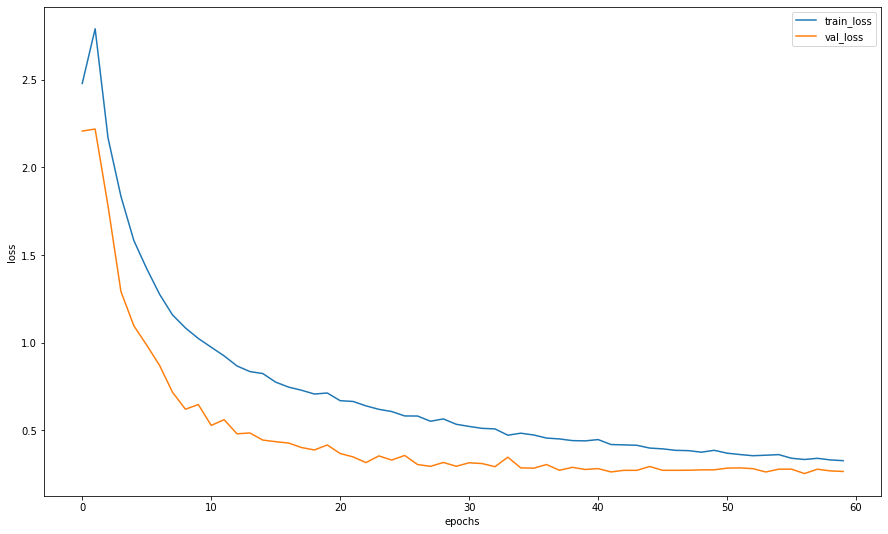

In [80]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Данный результат даёт скор около 0.98-0.99 на kaggle.

Посмотрим что получилось:

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [0]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_extractor, ex_img.unsqueeze(0))

In [0]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Вычислим целевую метрику f1-score на валидационной выборке.

In [86]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred,  average='weighted')

0.9397435897435897

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

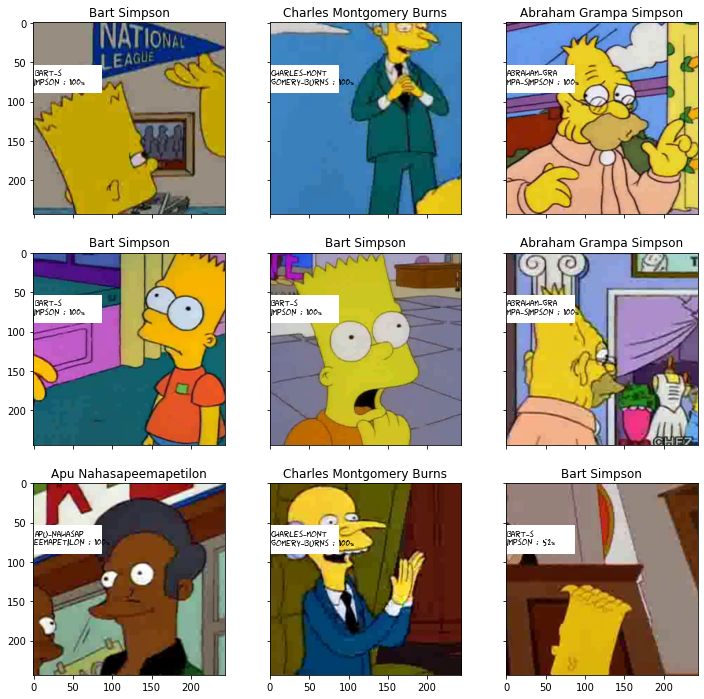

In [87]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_extractor, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [0]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model_extractor, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [89]:
import pandas as pd
my_submit = pd.read_csv("/content/gdrive/My Drive/simpsons/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:
my_submit.to_csv('gdrive/My Drive/simpsons/resnet18_fullnet_batch128_60epochs.csv', index=False)